## LLaMA Model İncelemesi
LLaMA modeli, geleneksel transformer modelleriyle farklılık gösterse de aslında ikisinin de amacı geçmiş tokenlara bakarak token üretmektir. Yani ikisi de geçmişteki veriye bakarak bir sonraki tokenı üretir ama bunu yaparken farklı yaklaşımlar izler.

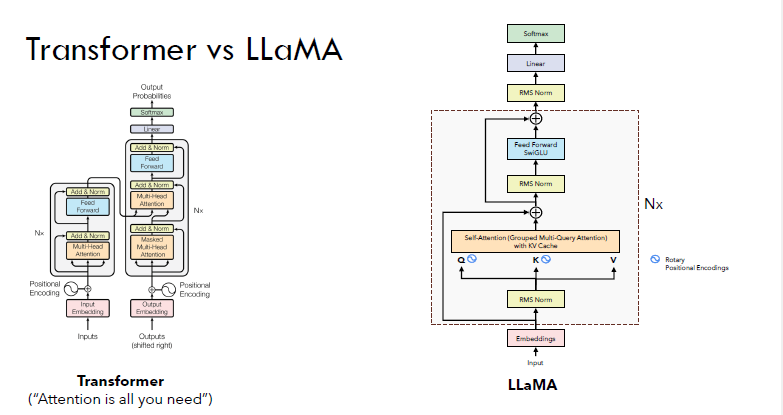

Yukarıdaki şekilde de görüldüğü üzere geleneksel transformer yaklaşımında gelen embeddinge multi head attention uygulanır. Burada key query ve value değerlerindeki head sayıları aynıdır. Ama bu LLaMA modelinde farklılık gösterir. Ayrıca LLaMA modellerinde geleneksel transformer modellerinin aksine bütün tokenlar baştan üretilmez. Cache'e atılır bu da çalışma süresini O(n^2) ' den O(n)'e düşürür. Bunlara daha sonra değineceğiz. Şimdilik LLaMA modellerinin Self Attention, Embedding kısımlarında geleneksel transformer modellerinden farklı olduğunu Ayrıca aktivasyon fonksiyonu olarak ReLU yerine SwiGLU kullandığını ve geleneksel normalizasyon yerine Root Mean Square (Ortalama Karelerin Karekökü)'nü kullandığını bilmemiz yeterli olacaktır.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import math

In [ ]:
class Params():
  def __init__(self) -> None:
     self.dim = 4096
     self.n_layers = 32
     self.n_heads = 32
     self.n_kv_heads = 8
     self.vocab_size = 128256
     self.multiple_of = 1024
     self.ffn_dim_multiplier = 1.3
     self.norm_eps = 1e-05
     self.rope_theta = 500000.0

In [3]:
params = Params()

## LLaMA Modelindeki Embedding'in İncelenmesi
LLaMA modelinde geleneksel transformerlardan farklı olarak Embedding vektörü reel olmayan düzlemden Euler formülü aracılığıyla türetilir. Klasik Transformer modellerinde, kelime embedding’lerine ek olarak bir pozisyon (sıra) embedding’i oluşturulur ve bu iki vektör toplanarak modele pozisyon bilgisi kazandırılır. Ancak bu yaklaşım mutlak (absolute) konum bilgisi içerdiğinden, giriş dizisinin uzunluğu context_length parametresini aştığında pozisyon bilgisinin genellenebilirliği zayıflar. Bu sorunu aşmak için, LLaMA modellerinde sinüs ve kosinüs fonksiyonlarının periyodik yapısından yararlanan RoPE (Rotary Positional Embedding) yöntemi kullanılmaktadır.

## Absolute Ve Relative Positional Encoding Arasındaki Farklar

Absolute positional encoding ilgili tokenın cümledeki pozisyon bilgisini içereceğinden her seferinde bir tokenla uğraşır ancak relative positional encoding bu pozisyon bilgisinin yanı sıra iki token arasındaki mesafe bilgisini de içereceğinden dolayı her seferinde iki token ile uğraşır.

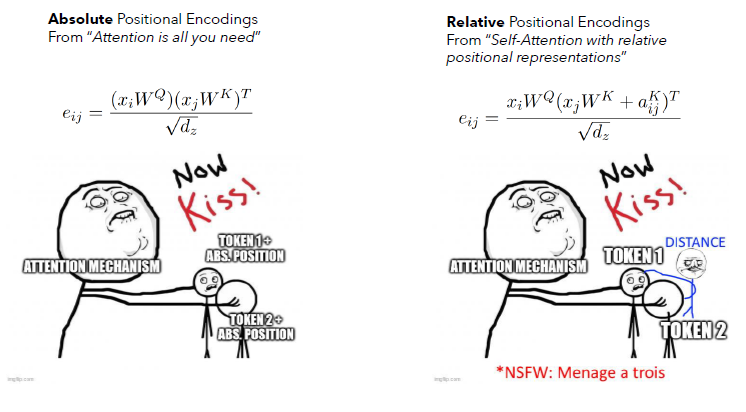

[Kaynak - Umar Jamil Coding LLaMA 2 From Scratch]

Yukarıdaki şekilde de görüldüğü üzere geleneksel transformer mimarisinde formülümüz Q @ K.T / sqrt(dim) şeklinde iken relative positional encodingte Q @ (K + dist_matrix).T / sqrt(dim) şekline gelmiştir. Bu da vektörlerin sıra bilgisiyle değil birbirleri arasındaki mesafe ile tutulduğunu gösterir. Bu yaklaşım zero-shot'ta yüksek performans gösterir.
Rotary Positional Encoding paperının yazarları işlemleri inner product ile yapmıştır. Bu da dot productın reel olmayan düzlemdeki hali gibi düşünülebilir dolayısıyla bir dizi matematiksel işlem yapmaya ve Calculus 2 dersine geri dönmeye hazır olun.

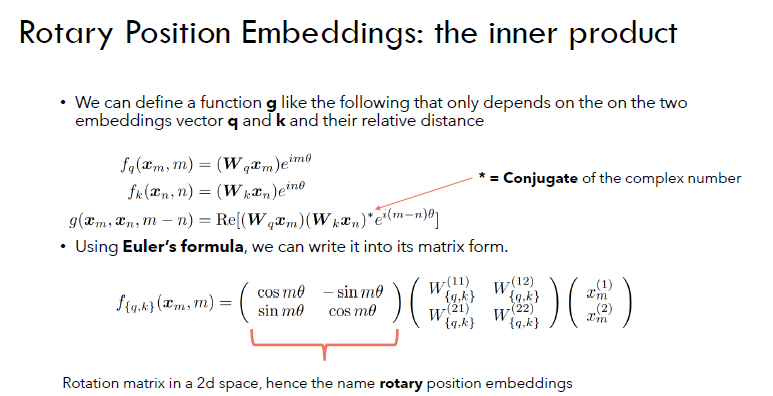

[Kaynak - Umar Jamil]

Yukarıdaki şekilde de görüldüğü üzere key ve query matrisleri mesafeleri de içeren bir g fonksiyonuna çevrildiğinde ve Euler formülü de kullanıldığında kosinüs ve sinüs elde ederiz. Buradaki kosinüs ve sinüslü matris de döndürme matrisi (rotation matrix)tir. Ancak bu işlem 2 boyutlu düzlemdedir. Bunu çok boyutlu düzleme aktarırsak aşağıdaki şekildeki gibi bir matris elde ederiz.

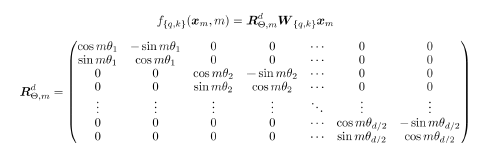

Burada theta parametresi yazarların belirttiği üzere 10000 ^ (-2(i-1) / d) formülü ile bulunur.

Yukarıdaki resimdeki sparse matris boş yere yer kaplayacağı ve bellekte ziyana yol açacağı için yukarıdaki işlemi şuna dönüştürebiliriz:

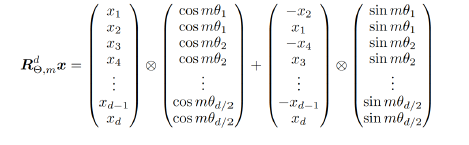


Küçük bir örneklem kümesi üzerinde RoPe formülünün Euler formülü ile ispatı

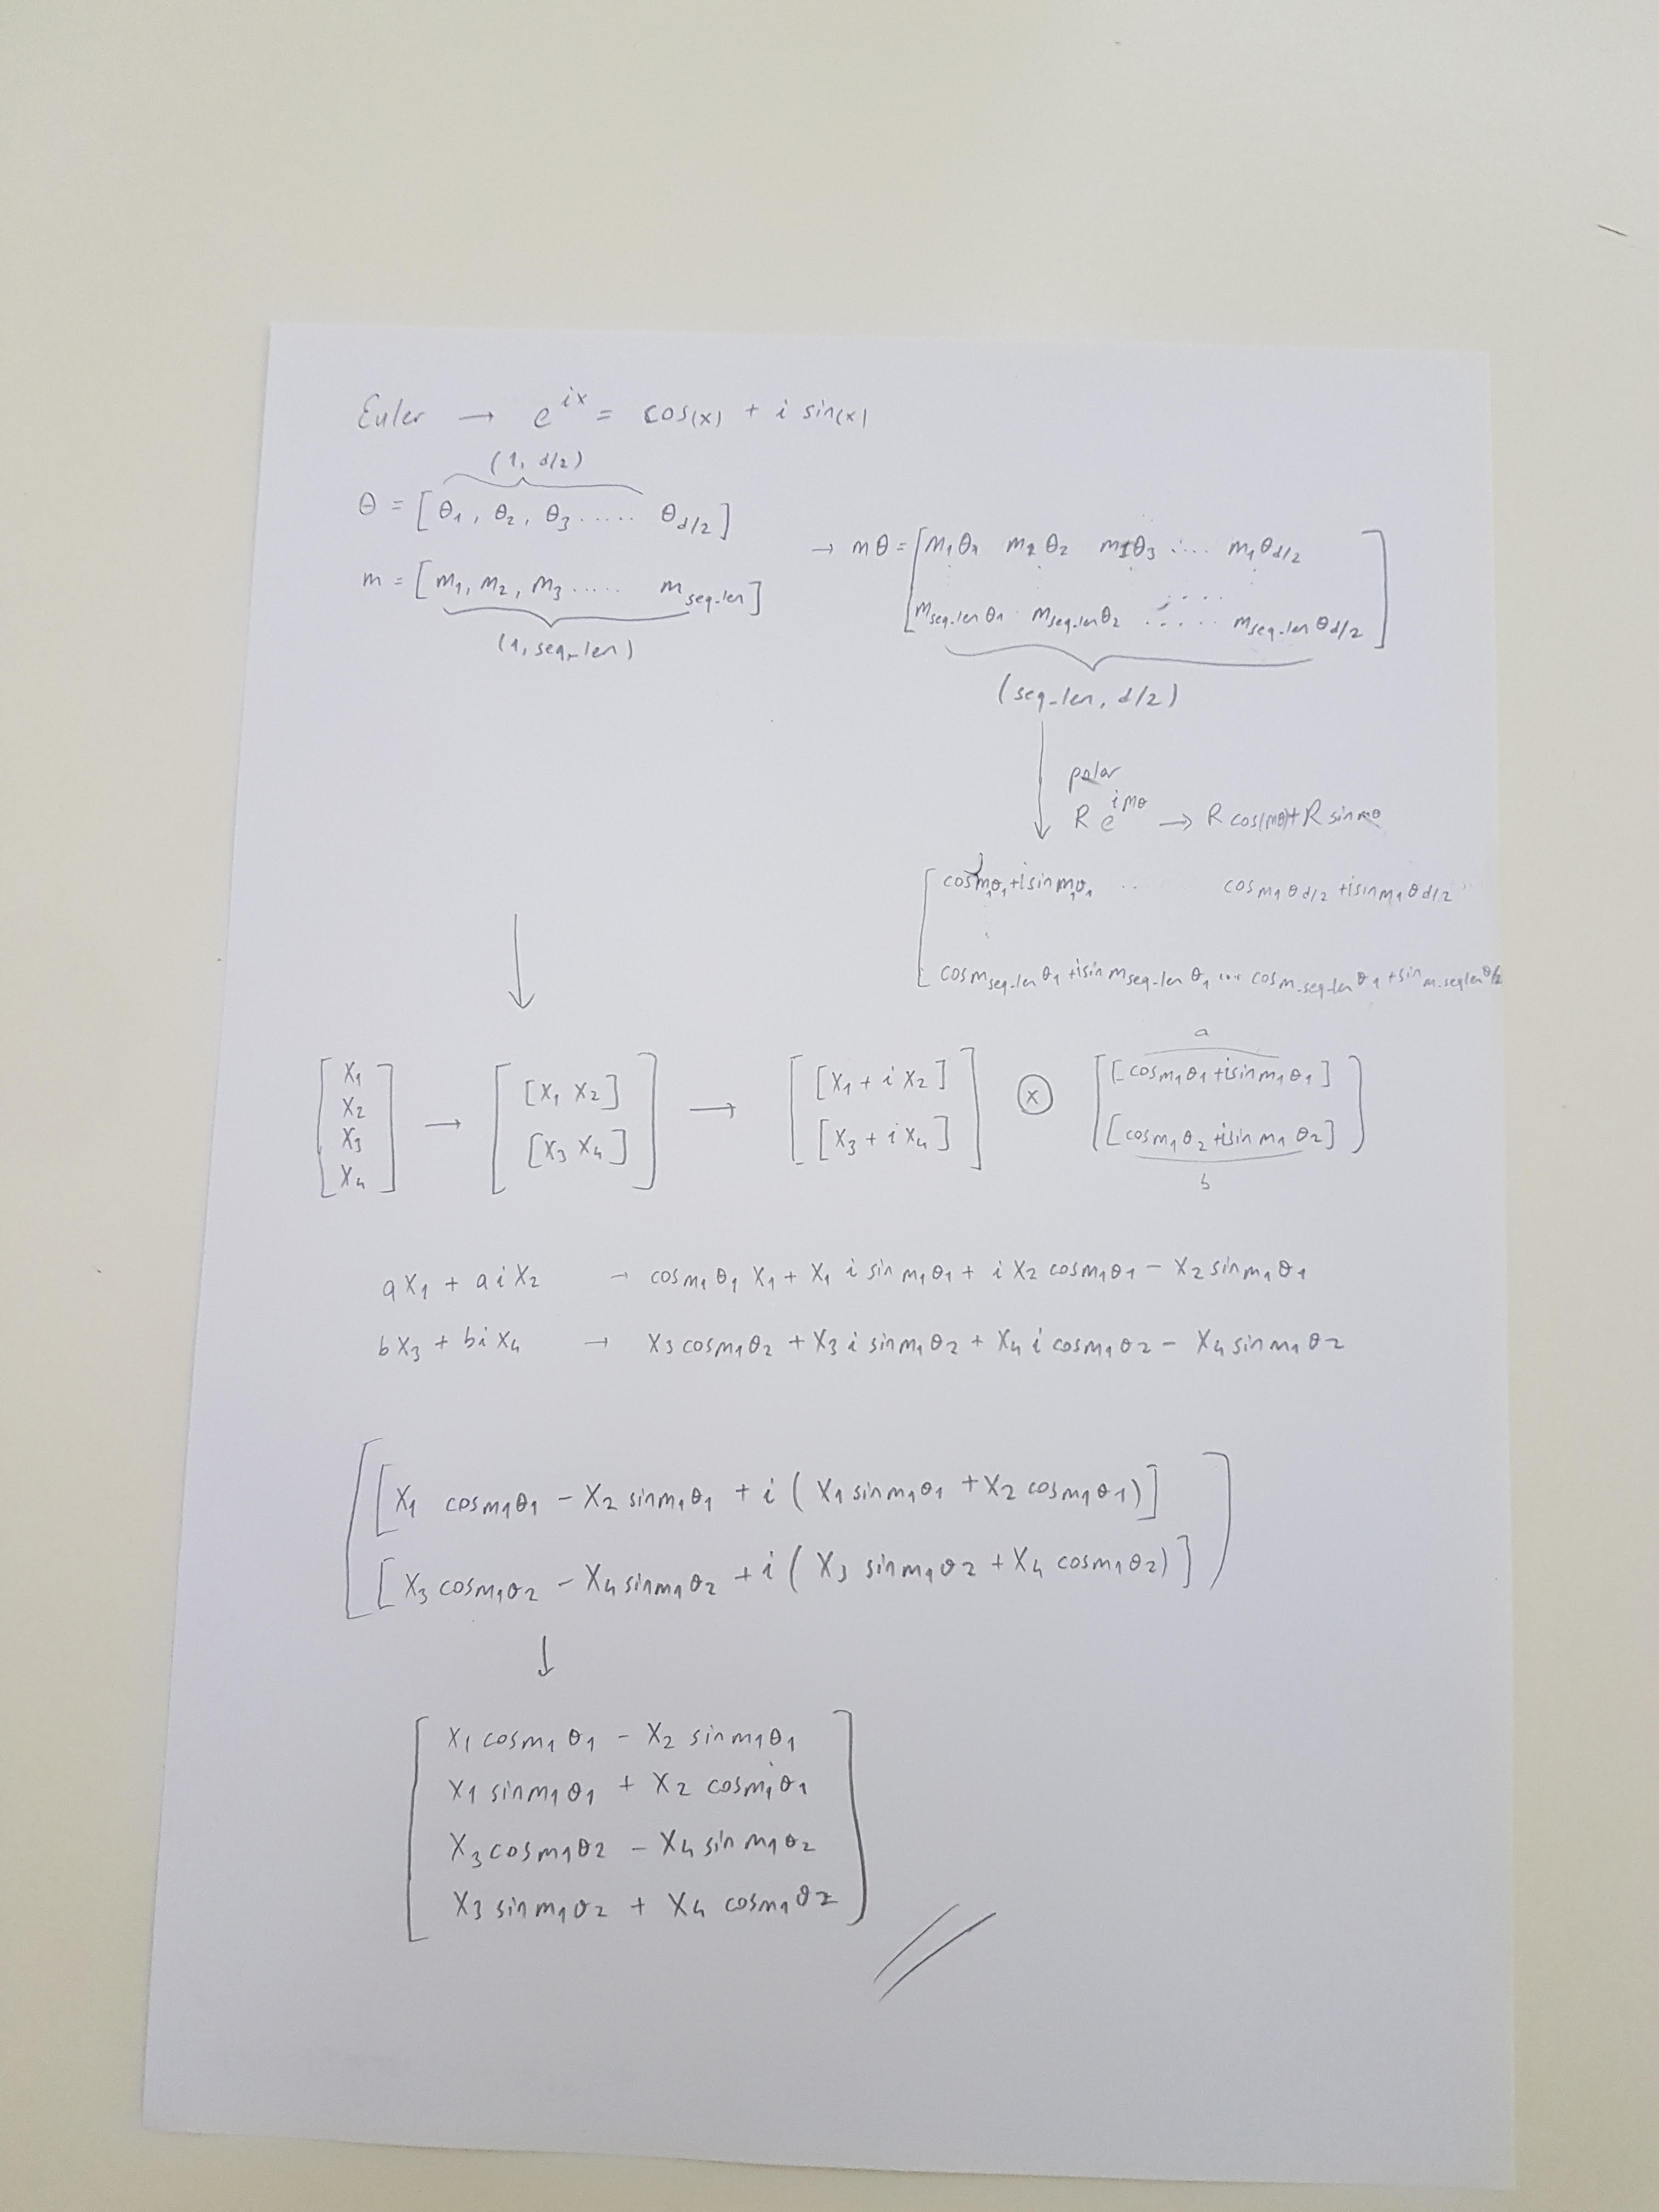

In [4]:
def compute_theta_freqs(seq_len:int, dim:int, theta:float, device: str) -> torch.Tensor:
  assert dim % 2 == 0, "Boyutlar çift olmalıdır..."
  # (dim / 2)
  theta_freqs = torch.arange(0, dim, 2, device = device).float()
  thetas = 1.0 / (theta ** (theta_freqs / dim))
  # (seq_len)
  m = torch.arange(0, seq_len, device = device)
  # (seq_len, dim / 2)
  m_theta_freqs = torch.outer(m, thetas)
  freqs_complex = torch.polar(torch.ones_like(m_theta_freqs), m_theta_freqs)
  return freqs_complex

In [ ]:
def apply_rotary_embeddings(x:torch.Tensor, freqs_complex:torch.Tensor) -> torch.Tensor:
  # Biz bunu k ve q ya uygulayacağımız için girdi shape i (batch_size, seq_len, h, head_dim)
  batch_size, n_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "girdinin son boyutu çift olmalıdır..."
  # (batch_size, n_heads, seq_len, head_dim) -> (batch_size, n_heads, seq_len, head_dim // 2, 2)
  x_reshaped = x.float().reshape(batch_size, n_heads, seq_len, head_dim // 2, 2)
  # (batch_size, n_heads, seq_len, head_dim/2, 2) -> (batch_size, n_heads, seq_len, head_dim/2)
  x_complex = torch.view_as_complex(x_reshaped.contiguous())
  # (seq_len, dim / 2) -> (1, 1, seq_len, head_dim / 2)
  freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(1)
  #  (batch_size, n_heads, seq_len, head_dim/2) * (1, 1, seq_len, head_dim/2) -> (batch_size, n_heads, seq_len, head_dim/2)
  rope_embed = x_complex * freqs_complex
  # (batch_size, n_heads, seq_len, head_dim /2) -> (batch_size, n_heads, seq_len, head_dim)
  x_real = torch.view_as_real(rope_embed)
  return x_real.view(x.shape)

Embedding kısmını hallettiğimize göre Normalizasyon kısmına gelebiliriz. Klasik transformer modellerinde normalizasyon işlemi ortalama ve varyans yardımıyla bulunur ve
(x - mean) / var şeklinde formül uygulanır. Bu da  veri dağılımını ortalaması 0'a varyansı 1'e yakın hale getirmeye çalışır ve Gaussian dağılıma benzetir. Ancak LLaMA modellerinde bu yaklaşım yerine RMSNormalization yaklaşımı izlenmektedir. Burada ortalamaların karelerinin karekökü alınır. Ayrıca RMSNorm yöntemi klasik Layer Normalization yönteminden daha az işlem ve parametre içermektedir. Büyük modellerde ortalama çıkarma işlemi küçük farkların büyümesine de neden olabileceğinden RMSNorm yönteminde ortalama çıkarılmaz.

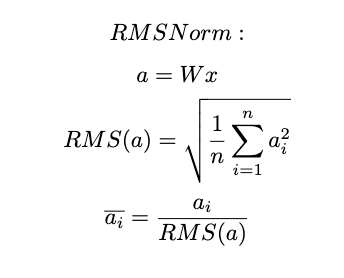

In [ ]:
class RMSNorm(nn.Module):
  def __init__(self, params:Params) -> None:
    super().__init__()
    self.eps = params.norm_eps
    self.gamma = nn.Parameter(torch.ones(params.dim))
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    norm_x = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    return self.gamma * norm_x

Şimdi sıra Self-Attention mekanizmasında. Bu mekanizmaya önceki modellerde değinmiştik. Kısaca anlatmamız gerekirse oluşan embedding'i kendi içerisinde nxn lik bir matris yapılması ve bu matrislerden aynı şekilde key, query ve value değerlerinin çıkarılıp attention formülünün uygulanmasıydı. LLaMA modeli ile birlikte önemli bir özellik geldi. Bu da KV Cache mekanizması. Peki nedir bu KV Cache?
Geleneksel transformer yönteminde her bir token her seferinde yeniden üretilir ve transformerlar da Seq2Seq model olduğu için çıktı da girdi kadardır. Dolayısıyla çıktıda girdideki tokenları da görmek mümkündür. İşte bu nedenlerden dolayı önceki girdileri tutan ve her zaman Query'nin son kısmını girdi olarak alan KV Cache yapısına ihtiyaç vardır.

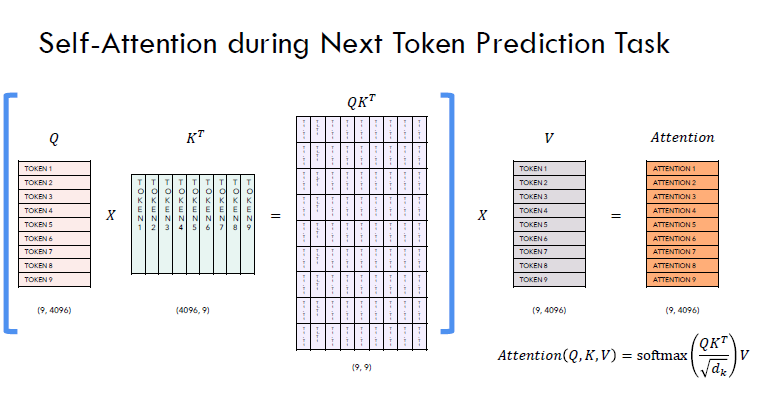

Yukarıdaki şekilde de görüldüğü üzere klasik transformer modellerde her bir Query için Key'in transpose'u alınır ve işlem tekrar tekrar yapılır. Bu da O(n^2)'lik bir çalışma süresine tekabül eder. Ayrıca bütün attention skorları ile de ilgilenmiyoruz. Bizim işimize yarayacak olan son tokendan gelen attention skoru. Geçmiş tokenları zaten tahmin ettik.

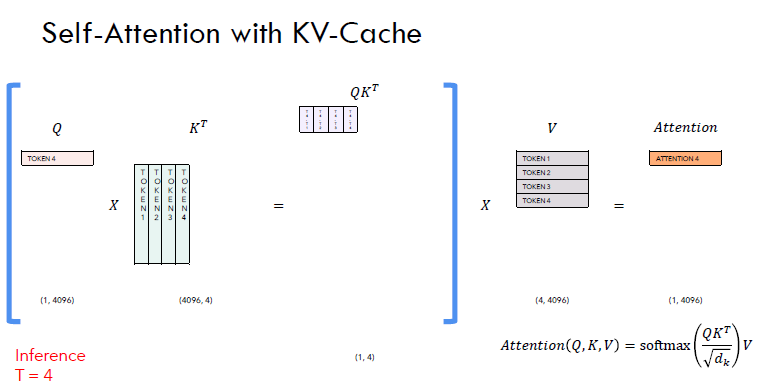

Yukarıdaki şekilde de görüldüğü üzere T = 4 anında Query'nin geçmiş tokenları yok sadece o anki tokenı var. Key ve Value'da ise geçmiş tokenlar tutulmakta.

## Grouped Multi Query Attention

Klasik Transformer mimarisinde, Query (Q), Key (K) ve Value (V) matrislerinin her biri aynı sayıda attention head’e sahiptir. Bu yapı güçlü bir temsil kapasitesi sağlasa da, özellikle büyük modellerde hesaplama maliyetini ve bellek kullanımını ciddi şekilde artırmaktadır. Bu da GPU'larda bottleneck'e sebep olmaktadır.

Bu nedenle, daha verimli bir yaklaşım olarak Multi-Query Attention (MQA) geliştirilmiştir. MQA’da Query tarafındaki head sayısı korunurken, Key ve Value matrislerindeki head sayısı azaltılmıştır. Böylece her Query head’i, paylaşılmış daha az sayıda Key ve Value setiyle etkileşir. Boyutların uyuşması için Key ve Value temsilcileri uygun şekilde kopyalanarak (replication) Query head’leriyle eşleştirilir. Bu yöntem, bellek kullanımını büyük oranda azaltırken hesaplama hızını da artırır. Ancak, farklı head’lerin aynı Key/Value bilgilerini paylaşması nedeniyle modelin temsil çeşitliliğinde bir miktar azalma gözlemlenir.

Daha dengeli bir çözüm olarak Grouped Query Attention (GQA) önerilmiştir. GQA’da Query head’leri belirli gruplara ayrılır ve her grup kendi Key ve Value setini paylaşır. Böylece MQA’ya kıyasla daha fazla bilgi çeşitliliği korunurken, klasik Multi-Head Attention’a göre bellek kullanımı ve hesaplama maliyeti önemli ölçüde azalır.

Özetle, attention head’leri modelin çıkarabileceği farklı özellikleri (feature’ları) temsil eder. Multi-Query Attention (MQA) maksimum verim sağlarken, Grouped-Query Attention (GQA) verimlilik ile temsil gücü arasında bir denge kurar.

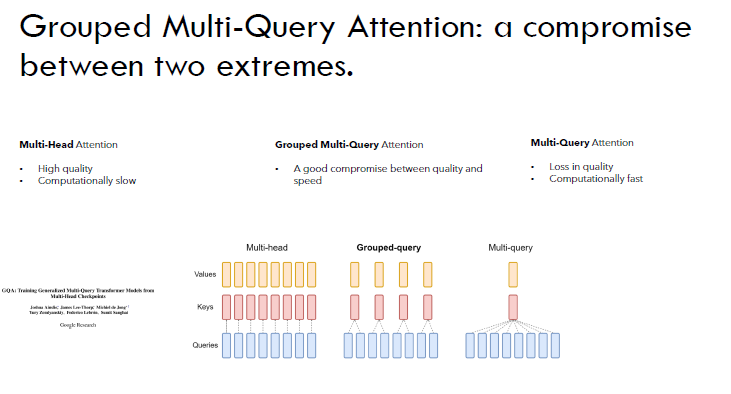

In [ ]:
class MultiheadGroupedQueryAttention(nn.Module):
  def __init__(self, params:Params) -> None:
    super().__init__()
    self.dim = params.dim
    self.n_kv_heads = params.n_kv_heads
    self.n_heads = params.n_heads
    assert self.dim % self.n_heads == 0, "Boyutlar başlık sayısına tam bölünebilir olmalıdır..."
    self.head_dim = self.dim // self.n_heads
    self.rep = self.n_heads // self.n_kv_heads
    assert self.n_heads % self.n_kv_heads == 0, "n_heads, n_kv_heads'a tam bölünebilmelidir"
    self.theta = params.rope_theta
    self.query = nn.Linear(self.dim, self.n_heads * self.head_dim, bias = False)
    self.key = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias = False)
    self.value = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias = False)
    self.proj = nn.Linear(self.dim, self.dim, bias = False)

  def forward(self, x:torch.Tensor, mask:torch.Tensor | None = None, cache = None) -> tuple:
    # (batch_size, seq_len, dim) -> (batch_size, seq_len, self.n_heads, self.head_dim)
    batch_size, seq_len, _ = x.shape
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    # (batch_size, seq_len, self.n_heads, self.head_dim) -> (batch_size, self.n_heads, seq_len, self.head_dim)
    q = q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
    # (batch_size, seq_len, self.n_kv_heads, self.head_dim) -> (batch_size, self.n_kv_heads, seq_len, self.head_dim)
    k = k.view(batch_size, seq_len, self.n_kv_heads, self.head_dim).transpose(1, 2)
    v = v.view(batch_size, seq_len, self.n_kv_heads, self.head_dim).transpose(1, 2)
    theta_freqs = compute_theta_freqs(seq_len, self.head_dim, theta = self.theta, device = x.device)
    # (batch_size, seq_len, self.n_heads, self.head_dim / 2, 2) -> (batch_size, seq_len, self.n_heads, self.head_dim)
    q = apply_rotary_embeddings(q, theta_freqs)
    # (batch_size, seq_len, self.n_kv_heads, self.head_dim / 2, 2) -> (batch_size, seq_len, self.n_kv_heads, self.head_dim)
    k = apply_rotary_embeddings(k, theta_freqs)

    # cache boş değilse cache'e ekle
    if cache is not None:
      k = torch.cat([cache['k'], k], dim=2)
      v = torch.cat([cache['v'], v], dim=2)
      cache['k'], cache['v'] = k, v
        
    k = k.repeat_interleave(self.rep, dim = 1)
    v = v.repeat_interleave(self.rep, dim = 1)
    # Maskeleme yapalım - cache kullanıyorsak toplam uzunluğu dikkate al
    kv_seq_len = k.size(2)
    if mask is None:
      mask = torch.ones(seq_len, kv_seq_len, device = x.device).tril(diagonal=kv_seq_len-seq_len).bool()# Maskeleme yapalım.
   #(1, 1, seq_len, seq_len)
    mask = mask.unsqueeze(0).unsqueeze(0)
    # (batch_size, n_kv_heads, seq_len, self.head_dim) -> (batch_size, n_kv_heads, self.rep, seq_len, self.head_dim)
    #k_expanded = k.unsqueeze(2).expand(batch_size, self.n_kv_heads, self.rep, k.size(2), k.size(3))
    #v_expanded = v.unsqueeze(2).expand(batch_size, self.n_kv_heads, self.rep, v.size(2), v.size(3))
    # (batch_size, n_kv_heads, self.rep, seq_len, self.head_dim) -> (batch_size, self.n_q_heads, seq_len, self.head_dim)    
    #k_expanded = k_expanded.reshape(batch_size, self.n_kv_heads * self.rep, seq_len, self.head_dim)
    #v_expanded = v_expanded.reshape(batch_size, self.n_kv_heads * self.rep, seq_len, self.head_dim)
    # (batch_size, self.n_heads, seq_len, self.head_dim) @ (batch_size, self.n_heads, self.head_dim, seq_len) -> (batch_size, self.n_heads, seq_len, seq_len)
    attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
    # Mask none değilse maske dışındaki yerlere -inf doldur ki softmaxte 0 çıksın
    attn_scores = attn_scores.masked_fill(~mask, float("-inf"))
    attn_weights = F.softmax(attn_scores, dim=-1)
    # (batch_size, self.n_heads, seq_len, seq_len) @ (batch_size, self.n_heads, seq_len, self.head_dim) -> (batch_size, self.n_heads, seq_len, self.head_dim)
    out = attn_weights @ v
    # (batch_size, self.n_heads, seq_len, self.head_dim) -> (batch_size, seq_len, self.n_heads, self.head_dim) -> (batch_size, seq_len, self.dim)
    out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.dim)
    out = self.proj(out)
    return out, cache


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, params: Params) -> None:
        super().__init__()
        self.d_model = params.dim
        self.multiple_of = params.multiple_of
        hidden_dim = int((self.d_model * params.ffn_dim_multiplier) / self.multiple_of + 0.5) * self.multiple_of
        self.hidden_dim = self.multiple_of * ((hidden_dim + self.multiple_of - 1) // self.multiple_of)
        # W1 ve W3 girişe uygulanır, W2 çıkışı üretir.
        self.w1 = nn.Linear(self.d_model, self.hidden_dim, bias=False)
        self.w3 = nn.Linear(self.d_model, self.hidden_dim, bias=False)
        self.w2 = nn.Linear(self.hidden_dim, self.d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # SwiGLU aktivasyonu (Swish + Gated Linear Unit)
        # x_gate = W1(x)
        # x_body = W3(x)
        # output = W2(SiLU(x_gate) * x_body)
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

In [9]:
class LLaMABlock(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.attn_norm = RMSNorm(params)
        self.mhgqa = MultiheadGroupedQueryAttention(params)
        self.ffn_norm = RMSNorm(params)
        self.ffn = FeedForward(params)

    def forward(self, x: torch.Tensor, mask: torch.Tensor | None = None, cache=None) -> torch.Tensor:
        residual = x
        x = self.attn_norm(x)
        x = self.mhgqa(x, mask=mask, cache=cache)[0]
        x = x + residual
        residual2 = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + residual2
        return x


In [10]:
class LLaMA3(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.emb = nn.Embedding(params.vocab_size, params.dim)
        self.llama_blocks = nn.ModuleList([LLaMABlock(params) for _ in range(params.n_layers)])
        self.norm = RMSNorm(params)
        self.head = nn.Linear(params.dim, params.vocab_size, bias=False)

    def forward(self, x: torch.Tensor, mask: torch.Tensor | None = None, cache=None) -> torch.Tensor:
        x = self.emb(x)
        for block in self.llama_blocks:
            x = block(x, mask=mask, cache=cache)
        x = self.norm(x)
        logits = self.head(x)
        return logits

Sistem noksanlıklarından dolayı bu kod yüksek GB'lı sistemlerde ya da büyük GPU'larda çalışacaktır. Dolayısıyla yüksek sisteminiz yoksa model device'a aktarılırken sistem hata verecektir. İmplementasyonda bir hata olduğunu düşünüyorsanız lütfen iletişime geçiniz.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LLaMA3(params)
model = model.to(device, dtype = torch.int8)
total_params = sum(p.numel() for p in model.parameters())
print(f"Toplam parametre sayısı: {total_params:,}")